In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ConvLSTM NDVI forecasting using NDVI, LST and LAI
- 3 timestep of 9 images as input (3 NDVI, 3 LST and 3 LAI) with 3 timestep output (3 NDVI images) (distinct timestep)
- NDVI:
  - source: MODIS/061/MOD13A2
  - interval: 16 days
  - resolution 1km
  - image: 84x65 pixel
- LST:
  - source: MODIS/006/MOD11A2
  - interval: 16 days (by default 8-days)
  - resolution 1km
  - image: 84x65 pixel
- LAI:
  - source: MODIS/061/MOD15A2H
  - interval: 16 days (by default 8-days)
  - resolution 1km (by default 500m)
  - image: 84x65 pixel

In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 44.9 MB/s eta 0:00:00


In [4]:
import rasterio
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Preparing NDVI data

In [5]:
ndvi_path = './NDVI-data-65x84'
ndvi_tif_files = glob.glob(ndvi_path+"/*.tif")

ndvi_tif_files.sort()
len(ndvi_tif_files)

526

In [6]:
ndvi_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in ndvi_tif_files]

print(ndvi_data_dates[-5:])
print('\n', len(ndvi_data_dates))

## date indexing

periods = [period for period in range(0, len(ndvi_data_dates), 6)]
ndvi_dataset_dates = []
for i in range(len(ndvi_data_dates)-5):
  period_date = []
  for date in ndvi_data_dates[i:i+6]:
    period_date.append(date)
  period_date_arr = np.array(period_date)
  ndvi_dataset_dates.append(period_date_arr)

['2022_10_16', '2022_11_01', '2022_11_17', '2022_12_03', '2022_12_19']

 526


In [ ]:
len(ndvi_dataset_dates)

521

In [7]:
ndvi_dataset_dates_arr = np.array(ndvi_dataset_dates[:518])

In [8]:
len(ndvi_dataset_dates_arr)

518

In [9]:
crs_list = []
transform_list = []

periods = [period for period in range(0, len(ndvi_tif_files), 6)]
ndvi_dataset = []
for i in range(len(ndvi_tif_files)-5):
  period_data = []
  for file_ in ndvi_tif_files[i:i+6]:
    ndvi_data = rasterio.open(file_)
    ndvi_data_arr = ndvi_data.read(1)
    ndvi_data_crs = ndvi_data.crs  # Get the coordinate reference system (CRS)
    crs_list.append(ndvi_data_crs)
    ndvi_data_transform = ndvi_data.transform # Get the transformation matrix
    transform_list.append(ndvi_data_transform)
    period_data.append(ndvi_data_arr)
  period_data_arr = np.array(period_data)
  ndvi_dataset.append(period_data_arr)

In [ ]:
crs_list[0]

CRS.from_wkt('PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [ ]:
transform_list[0]

Affine(1186.725317338362, 0.0, 8248059.345985923,
       0.0, -698.5949154338473, 1331776.4961396866)

In [ ]:
len(ndvi_dataset)

517

In [10]:
ndvi_dataset_arr = np.array(ndvi_dataset[:518])
ndvi_dataset_arr.shape

(518, 6, 84, 65)

In [11]:
samples = ndvi_dataset_arr.shape[0]
time_steps = ndvi_dataset_arr.shape[1]
height, width = ndvi_dataset_arr.shape[2], ndvi_dataset_arr.shape[3]
channels = 1

ndvi_data_raw = ndvi_dataset_arr.reshape(samples, time_steps, height, width, channels)

In [12]:
# Normalize NDVI values to range [0, 1]
ndvi_scaler = MinMaxScaler()
normalized_ndvi_data = ndvi_scaler.fit_transform(ndvi_data_raw.reshape(-1, 1))
ndvi_data = normalized_ndvi_data.reshape(518, 6, 84, 65, 1)

In [ ]:
import pickle

In [ ]:
sc_file = './summer-internship/model-training/ndvi_scaler.pkl'
with open(sc_file, 'wb') as file:
    pickle.dump(ndvi_scaler, file)

In [ ]:
print(ndvi_data.min())
print(ndvi_data.max())

0.0
0.9999999999999999


In [ ]:
ndvi_data.shape

(518, 6, 84, 65, 1)

In [ ]:
ndvi_data.shape[0]

518

In [13]:
indexes = np.arange(ndvi_data.shape[0])

train_index = indexes[: int(0.8 * ndvi_data.shape[0])]
val_index = indexes[int(0.8 * ndvi_data.shape[0]) :]

In [ ]:
ndvi_data.shape[0]

518

In [ ]:
indexes

In [ ]:
train_index

In [ ]:
val_index

array([414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504,
       505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517])

In [14]:
ndvi_train_dataset = ndvi_data[train_index, :, :, :, :]
ndvi_val_dataset = ndvi_data[val_index, :, :, :, :]

In [ ]:
ndvi_train_dataset.shape

(414, 6, 84, 65, 1)

In [ ]:
ndvi_dataset_dates_arr.shape

(518, 6)

In [15]:
ndvi_train_dataset_date = ndvi_dataset_dates_arr[train_index, :]
ndvi_val_dataset_date = ndvi_dataset_dates_arr[val_index, :]

In [ ]:
len(ndvi_train_dataset_date)

414

In [ ]:
ndvi_train_dataset_date[413]

array(['2018_02_02', '2018_02_18', '2018_03_06', '2018_03_22',
       '2018_04_07', '2018_04_23'], dtype='<U10')

In [ ]:
ndvi_train_dataset_date[-1]

array(['2018_02_02', '2018_02_18', '2018_03_06', '2018_03_22',
       '2018_04_07', '2018_04_23'], dtype='<U10')

In [ ]:
ndvi_val_dataset.shape

(104, 6, 84, 65, 1)

In [16]:
def create_shifted_frames(data):
    x = data[:, :data.shape[1]-3, :, :, :]
    y = data[:, -3:, :, :, :]
    return x, y


# Apply the processing function to the datasets.
x_train_ndvi, y_train_ndvi = create_shifted_frames(ndvi_train_dataset)
x_val_ndvi, y_val_ndvi = create_shifted_frames(ndvi_val_dataset)

In [17]:
print("Training Dataset Shapes: " + str(x_train_ndvi.shape) + ", " + str(y_train_ndvi.shape))
print("Validation Dataset Shapes: " + str(x_val_ndvi.shape) + ", " + str(y_val_ndvi.shape))

Training Dataset Shapes: (414, 3, 84, 65, 1), (414, 3, 84, 65, 1)
Validation Dataset Shapes: (104, 3, 84, 65, 1), (104, 3, 84, 65, 1)


In [ ]:
len(ndvi_train_dataset[-1])

10

In [ ]:
len(x_train_ndvi[-1])

9

In [ ]:
y_train_ndvi.shape

(414, 3, 84, 65, 1)

In [ ]:
y_train_ndvi[-1][0].shape

(84, 65, 1)

In [ ]:
(x_train_ndvi[-1][-1] == y_train_ndvi[-1][1]).all()

False

In [ ]:
#y_train_ndvi = y_train_ndvi.reshape(459, 1, 84, 65, 1)

In [ ]:
#y_val_ndvi = y_val_ndvi.reshape(51, 1, 84, 65, 1)

### Preparing LST data

In [18]:
lst_path = './LST-data-1km-65x84'
lst_tif_files = glob.glob(lst_path+"/*.tif")

lst_tif_files.sort()
len(lst_tif_files)

523

In [19]:
lst_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in lst_tif_files]

print(lst_data_dates[-5:])
print('\n', len(lst_data_dates))

## date indexing

periods = [period for period in range(0, len(lst_data_dates), 3)]
lst_dataset_dates = []
for i in range(len(lst_data_dates)-2):
  period_date = []
  for date in lst_data_dates[i:i+3]:
    period_date.append(date)
  period_date_arr = np.array(period_date)
  lst_dataset_dates.append(period_date_arr)

['2022_08_29', '2022_09_14', '2022_09_30', '2022_10_16', '2022_11_01']

 523


In [ ]:
ndvi_dataset_dates[-3]

array(['2022_08_29', '2022_09_14', '2022_09_30', '2022_10_16',
       '2022_11_01', '2022_11_17'], dtype='<U10')

In [ ]:
lst_dataset_dates[-3]

array(['2022_08_29', '2022_09_14', '2022_09_30'], dtype='<U10')

In [ ]:
ndvi_dataset_dates[-2]

array(['2022_09_14', '2022_09_30', '2022_10_16', '2022_11_01',
       '2022_11_17', '2022_12_03'], dtype='<U10')

In [ ]:
lst_dataset_dates[-2]

array(['2022_09_14', '2022_09_30', '2022_10_16'], dtype='<U10')

In [ ]:
ndvi_dataset_dates[-1]

array(['2022_09_30', '2022_10_16', '2022_11_01', '2022_11_17',
       '2022_12_03', '2022_12_19'], dtype='<U10')

In [ ]:
len(lst_dataset_dates)

515

In [26]:
lst_dataset_dates_arr = np.array(lst_dataset_dates[:518])
lst_dataset_dates_arr.shape

(518, 3)

In [20]:
lst_crs_list = []
lst_transform_list = []

periods = [period for period in range(0, len(lst_tif_files), 3)]
lst_dataset = []
for i in range(len(lst_tif_files)-2):
  period_data = []
  for file_ in lst_tif_files[i:i+3]:
    lst_data = rasterio.open(file_)
    lst_data_arr = lst_data.read(1)
    lst_data_crs = lst_data.crs  # Get the coordinate reference system (CRS)
    lst_crs_list.append(lst_data_crs)
    lst_data_transform = lst_data.transform # Get the transformation matrix
    lst_transform_list.append(lst_data_transform)
    period_data.append(lst_data_arr)
  lst_period_data_arr = np.array(period_data)
  lst_dataset.append(lst_period_data_arr)

In [ ]:
lst_crs_list[0] == crs_list[0]

True

In [ ]:
crs_list[0]

CRS.from_wkt('PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [ ]:
lst_transform_list[0] == transform_list[0]

False

In [21]:
lst_dataset_arr = np.array(lst_dataset[:518])
lst_dataset_arr.shape

(518, 3, 84, 65)

In [ ]:
(lst_dataset_arr[0][1:]==lst_dataset_arr[1][:-1]).all()

True

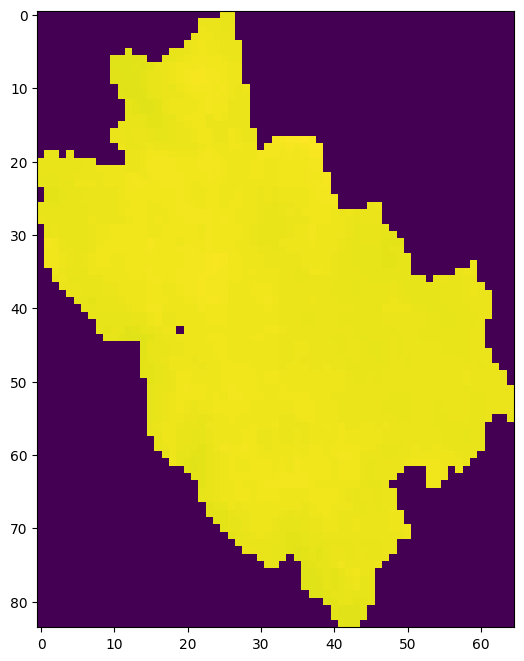

In [ ]:
# Plot the NDVI image using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(lst_dataset_arr[3][-1])

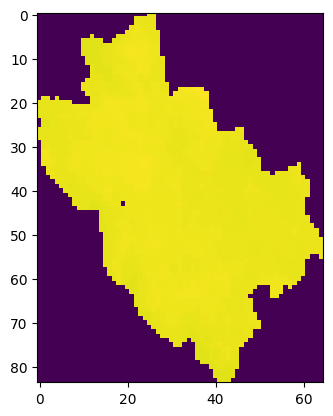

In [ ]:
# Construct a figure for the original and new frames.
plt.imshow(lst_dataset_arr[3][-1])
# Display the figure.
plt.show()

In [ ]:
print(lst_dataset_arr.min())
print(lst_dataset_arr.max())

0
15772


In [ ]:
lst_dataset_arr.mean()

5261.03868757602

In [ ]:
lst_dataset_arr[0][1].std()

7580.171909689151

In [ ]:
lst_dataset_arr.any()=='NaN'

False

In [ ]:
np.isnan(lst_dataset_arr).sum()

0

In [22]:
samples = lst_dataset_arr.shape[0]
time_steps = lst_dataset_arr.shape[1]
height, width = lst_dataset_arr.shape[2], lst_dataset_arr.shape[3]
channels = 1

lst_data_raw = lst_dataset_arr.reshape(samples, time_steps, height, width, channels)

In [ ]:
lst_data_raw.shape

(518, 3, 84, 65, 1)

In [23]:
lst_scaler = MinMaxScaler()
normalized_lst_data = lst_scaler.fit_transform(lst_data_raw.reshape(-1, 1))
lst_data = normalized_lst_data.reshape(518, 3, 84, 65, 1)

In [ ]:
sc_file = './summer-internship/model-training/lst_scaler.pkl'
with open(sc_file, 'wb') as file:
    pickle.dump(lst_scaler, file)

In [24]:
lst_train_dataset = lst_data[train_index, :, :, :, :]
lst_val_dataset = lst_data[val_index, :, :, :, :]

In [27]:
lst_train_dataset_date = lst_dataset_dates_arr[train_index, :]
lst_val_dataset_date = lst_dataset_dates_arr[val_index, :]

In [ ]:
(lst_val_dataset[0][-1]==lst_val_dataset[1][-2]).all()

True

In [ ]:
(lst_val_dataset[0][-1]==lst_val_dataset[2][-3]).all()

True

### Preparing LAI data

In [28]:
lai_path = './LAI-data-65x84'
lai_tif_files = glob.glob(lai_path+"/*.tif")

lai_tif_files.sort()
len(lai_tif_files)

525

In [ ]:
ndvi_tif_files[-1:]

['./NDVI-data-65x84/2022_12_19.tif']

In [ ]:
ndvi_tif_files[-6:]

['./NDVI-data-65x84/2022_09_30.tif',
 './NDVI-data-65x84/2022_10_16.tif',
 './NDVI-data-65x84/2022_11_01.tif',
 './NDVI-data-65x84/2022_11_17.tif',
 './NDVI-data-65x84/2022_12_03.tif',
 './NDVI-data-65x84/2022_12_19.tif']

In [ ]:
lst_tif_files[0]

'./LST-data-1km-65x84/2000_02_18.tif'

In [ ]:
lst_tif_files[-6:]

['./LST-data-1km-65x84/2022_08_13.tif',
 './LST-data-1km-65x84/2022_08_29.tif',
 './LST-data-1km-65x84/2022_09_14.tif',
 './LST-data-1km-65x84/2022_09_30.tif',
 './LST-data-1km-65x84/2022_10_16.tif',
 './LST-data-1km-65x84/2022_11_01.tif']

In [ ]:
lai_tif_files[-6:]

['./LAI-data-65x84/2022_09_14.tif',
 './LAI-data-65x84/2022_09_30.tif',
 './LAI-data-65x84/2022_10_24.tif',
 './LAI-data-65x84/2022_11_01.tif',
 './LAI-data-65x84/2022_11_17.tif',
 './LAI-data-65x84/2022_12_03.tif']

In [ ]:
lai_tif_files[-1]

'./LAI-data-65x84/2022_11_01.tif'

In [29]:
lai_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in lai_tif_files]

print(lai_data_dates[-5:])
print('\n', len(lai_data_dates))

## date indexing

periods = [period for period in range(0, len(lai_data_dates), 3)]
lai_dataset_dates = []
for i in range(len(lai_data_dates)-2):
  period_date = []
  for date in lai_data_dates[i:i+3]:
    period_date.append(date)
  period_date_arr = np.array(period_date)
  lai_dataset_dates.append(period_date_arr)

['2022_09_30', '2022_10_24', '2022_11_01', '2022_11_17', '2022_12_03']

 525


In [30]:
lai_dataset_dates_arr = np.array(lai_dataset_dates[:518])

In [31]:
lai_crs_list = []
lai_transform_list = []

periods = [period for period in range(0, len(lai_tif_files), 3)]
lai_dataset = []
for i in range(len(lai_tif_files)-2):
  period_data = []
  for file_ in lai_tif_files[i:i+3]:
    lai_data = rasterio.open(file_)
    lai_data_arr = lai_data.read(1)
    lai_data_crs = lai_data.crs  # Get the coordinate reference system (CRS)
    lai_crs_list.append(lai_data_crs)
    lai_data_transform = lai_data.transform # Get the transformation matrix
    lai_transform_list.append(lai_data_transform)
    period_data.append(lai_data_arr)
  lai_period_data_arr = np.array(period_data)
  lai_dataset.append(lai_period_data_arr)

In [32]:
lai_dataset_arr = np.array(lai_dataset[:518])
lai_dataset_arr.shape

(518, 3, 84, 65)

In [ ]:
lai_dataset_arr.any()=='NaN'

False

In [ ]:
np.isnan(lai_dataset_arr).sum()

0

In [ ]:
print(lai_dataset_arr.min())
print(lai_dataset_arr.max())

0
116


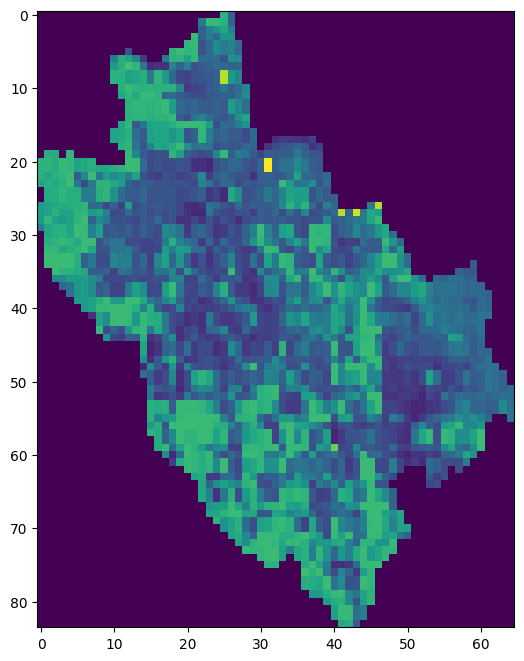

In [ ]:
# Plot the NDVI image using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(lai_dataset_arr[3][-1])

In [33]:
lai_data_raw = lai_dataset_arr.reshape(samples, time_steps, height, width, channels)

In [34]:
lai_scaler = MinMaxScaler()
normalized_lai_data = lai_scaler.fit_transform(lai_data_raw.reshape(-1, 1))
lai_data = normalized_lai_data.reshape(518, 3, 84, 65, 1)

In [ ]:
sc_file = './summer-internship/model-training/lai_scaler.pkl'
with open(sc_file, 'wb') as file:
    pickle.dump(lai_scaler, file)

In [35]:
lai_train_dataset = lai_data[train_index, :, :, :, :]
lai_val_dataset = lai_data[val_index, :, :, :, :]

In [36]:
lai_train_dataset_date = lai_dataset_dates_arr[train_index, :]
lai_val_dataset_date = lai_dataset_dates_arr[val_index, :]

In [ ]:
(lai_val_dataset[0][-1]==lai_val_dataset[1][-2]).all()

True

### Modelling

In [37]:
x_combined_train = np.concatenate((x_train_ndvi, lst_train_dataset, lai_train_dataset), axis=-1)
y_train = y_train_ndvi

x_combined_val = np.concatenate((x_val_ndvi, lst_val_dataset, lai_val_dataset), axis=-1)
y_val = y_val_ndvi

In [ ]:
y_val.shape

(104, 3, 84, 65, 1)

In [38]:
print(x_combined_train.shape)
print(x_combined_val.shape)

(414, 3, 84, 65, 3)
(104, 3, 84, 65, 3)


In [42]:
# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.

time_steps = 3
height = 84
width = 65
num_channels = 3

input_combined = tf.keras.layers.Input(shape=(time_steps, height, width, num_channels))

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    activation="relu",
)(input_combined)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

# Additional convolutional layers to predict NDVI
conv_out = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

In [43]:
# Create the model
model = tf.keras.models.Model(inputs=input_combined, outputs=conv_out)

# Compile the model
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy) #'mean_squared_error')

# Print model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 84, 65, 3)]    0         
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 3, 84, 65, 64)     840704    
                                                                 
 batch_normalization_3 (Bat  (None, 3, 84, 65, 64)     256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 3, 84, 65, 64)     819456    
                                                                 
 batch_normalization_4 (Bat  (None, 3, 84, 65, 64)     256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 84, 65, 64)     2951

In [44]:
## Model Training

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

## model checkpoint
model_ckpt = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/summer-internship/model-training/ndvi&lst&lai_50epoch_distinct_3to3_3channel_sigmoid.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 2

In [45]:
# Train the model
#model.fit(X_train, y_train, batch_size=2, epochs=20, validation_split=0.2)
# Fit the model to the training data.
model.fit(x_combined_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_combined_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_ckpt],
)

Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 0.5178
Epoch 1: val_loss improved from inf to 0.72031, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lst&lai_50epoch_distinct_3to3_3channel_sigmoid.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 43s 162ms/step - loss: 0.5178 - val_loss: 0.7203 - lr: 0.0010
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 0.5063
Epoch 2: val_loss improved from 0.72031 to 0.70058, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lst&lai_50epoch_distinct_3to3_3channel_sigmoid.h5
207/207 [==============================] - 33s 159ms/step - loss: 0.5063 - val_loss: 0.7006 - lr: 0.0010
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 0.5053
Epoch 3: val_loss improved from 0.70058 to 0.59544, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lst&lai_50epoch_distinct_3to3_3channel_sigmoid.h5
207/207 [==============================] - 34s 164ms/step - loss: 0.5053 - val_loss: 0.5954 - lr: 0.0010
Epoch 4/50
207/207 [==============================] - ETA: 0s - loss: 0.5040
Epoch 4: val_loss improved from 0.59544 to 0.51476, saving model to /content/drive/MyDrive/summe

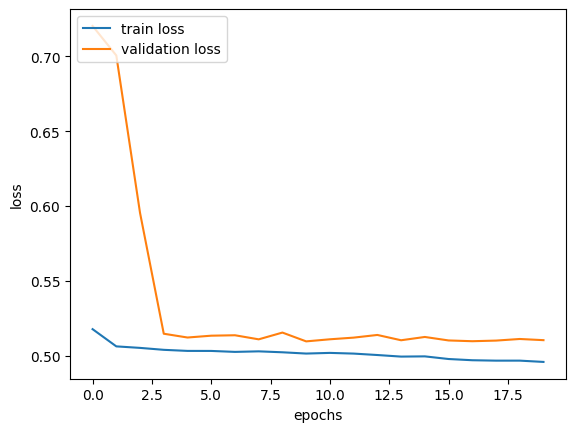

In [46]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Train the model
#model.fit(X_train, y_train, batch_size=2, epochs=20, validation_split=0.2)
# Fit the model to the training data.
model.fit(x_combined_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_combined_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_ckpt],
)

Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 0.0295
Epoch 1: val_loss improved from inf to 0.09613, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lst&lai_50epoch_distinct_3to3_3channel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 51s 161ms/step - loss: 0.0295 - val_loss: 0.0961 - lr: 0.0010
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 0.0232
Epoch 2: val_loss did not improve from 0.09613
207/207 [==============================] - 32s 155ms/step - loss: 0.0232 - val_loss: 0.1175 - lr: 0.0010
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 0.0227
Epoch 3: val_loss improved from 0.09613 to 0.03074, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lst&lai_50epoch_distinct_3to3_3channel.h5
207/207 [==============================] - 34s 162ms/step - loss: 0.0227 - val_loss: 0.0307 - lr: 0.0010
Epoch 4/50
207/207 [==============================] - ETA: 0s - loss: 0.0204
Epoch 4: val_loss improved from 0.03074 to 0.02517, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lst&lai_50epoch_distinct_3to3_3channel.h5
207/207 [==============================] - 34s 164ms/step - loss:

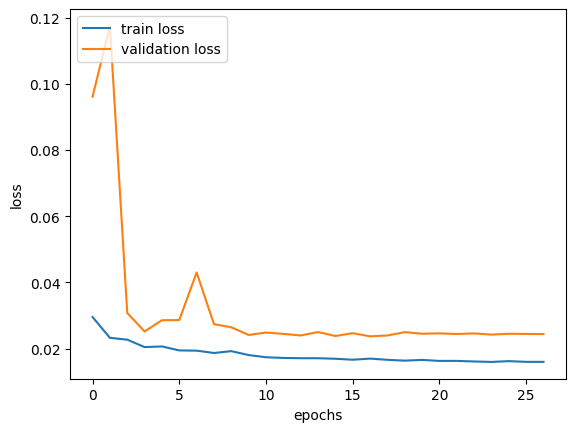

In [ ]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
load_model = tf.keras.models.load_model('./summer-internship/model-training/ndvi&lst&lai_50epoch_distinct_3to3_3channel.h5')

#### Keras Tuner

In [ ]:
def build_model(hp):
    input_combined = tf.keras.layers.Input(shape=(time_steps, height, width, num_channels))
    x = layers.ConvLSTM2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=(7, 7),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(input_combined)

    x = layers.BatchNormalization()(x)

    x = layers.ConvLSTM2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)

    x = layers.BatchNormalization()(x)

    x = layers.ConvLSTM2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values = [1, 3]),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.BatchNormalization()(x)

    x = layers.ConvLSTM2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size', values = [1, 3]),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)

    # Additional convolutional layers to predict NDVI
    conv_out = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation='linear', padding='same')(x)

    model = tf.keras.models.Model(inputs=input_combined, outputs=conv_out)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_loss',  # You can choose other metrics like 'val_accuracy'
    max_trials=10,         # Number of hyperparameter combinations to try
    directory='/content/drive/MyDrive/summer-internship/model-training/hyp-tuning',  # Directory to store tuner logs and checkpoints
    project_name='convlstm_tuning'  # Name of the tuning project
)


In [ ]:
tuner.search(x_combined_train, y_train, validation_data=(x_combined_val, y_val), epochs=25)

Trial 8 Complete [00h 01m 04s]

Best val_loss So Far: 0.04371120408177376
Total elapsed time: 01h 01m 29s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters

In [ ]:
final_model = build_model(best_hyperparameters)

In [ ]:
final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 84, 65, 3)]    0         
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 3, 84, 65, 96)     1863168   
                                                                 
 batch_normalization_3 (Bat  (None, 3, 84, 65, 96)     384       
 chNormalization)                                                
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 3, 84, 65, 96)     1843584   
                                                                 
 batch_normalization_4 (Bat  (None, 3, 84, 65, 96)     384       
 chNormalization)                                                
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 3, 84, 65, 96)     6639

In [47]:
x_combined_val[-1].shape

(3, 84, 65, 3)

In [54]:
%%time
y_prediction_ = model.predict(np.expand_dims(x_combined_val[0], axis=0))
y_prediction_.shape

1/1 [==============================] - 0s 87ms/step
CPU times: user 99.6 ms, sys: 2.03 ms, total: 102 ms
Wall time: 336 ms


(1, 3, 84, 65, 1)

In [55]:
y_prediction = np.squeeze(y_prediction_, axis=0)
y_prediction.shape

(3, 84, 65, 1)

#### Ploting input data

In [ ]:
lst_val_dataset_date[-1]

array(['2022_08_13', '2022_08_29', '2022_09_14'], dtype='<U10')

In [ ]:
x_combined_val[-1, :, :, :, 1].shape

(3, 84, 65)

LST input


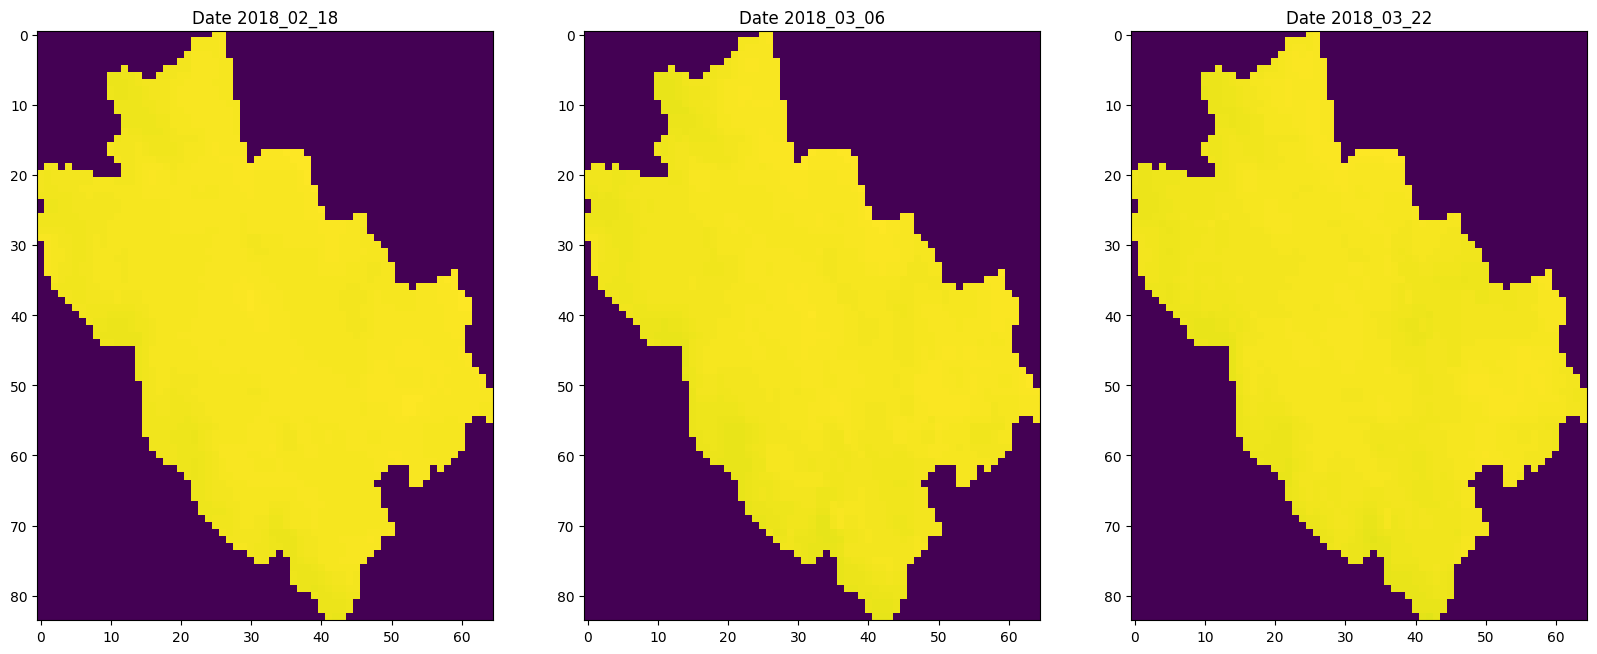

In [57]:
print('LST input')
fig = plt.figure(figsize= (20, 14))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {lst_val_dataset_date[0][i]}")
  ax.imshow(x_combined_val[0, :, :, :, 1][i])

In [58]:
lai_val_dataset_date[0]

array(['2018_02_18', '2018_03_06', '2018_03_22'], dtype='<U10')

LAI input


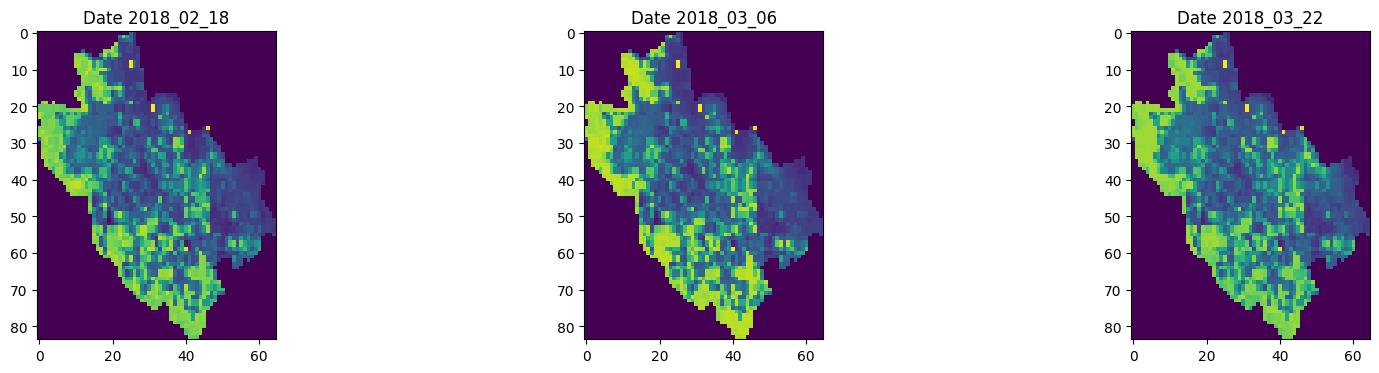

In [59]:
print('LAI input')
fig = plt.figure(figsize= (20, 4))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {lai_val_dataset_date[0][i]}")
  ax.imshow(x_combined_val[0, :, :, :, -1][i])

NDVI input


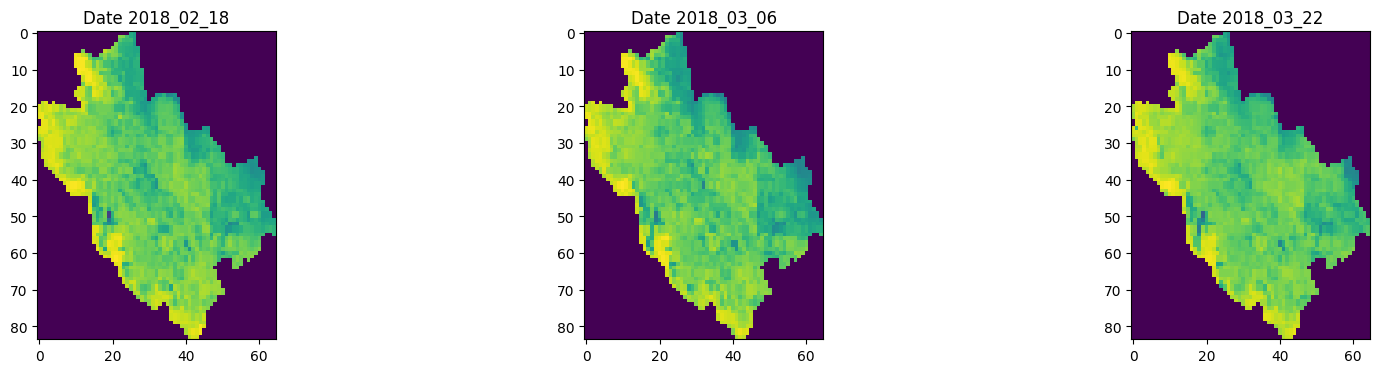

In [60]:
print('NDVI input')
fig = plt.figure(figsize= (20, 4))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {ndvi_val_dataset_date[0][i]}")
  ax.imshow(x_combined_val[0, :, :, :, 0][i])

#### Ploting Output

In [61]:
y_example_val = y_val[0]
y_example_val.shape

(3, 84, 65, 1)

In [62]:
ndvi_val_dataset_date[0][3:]

array(['2018_04_07', '2018_04_23', '2018_05_09'], dtype='<U10')

NDVI Actual Output


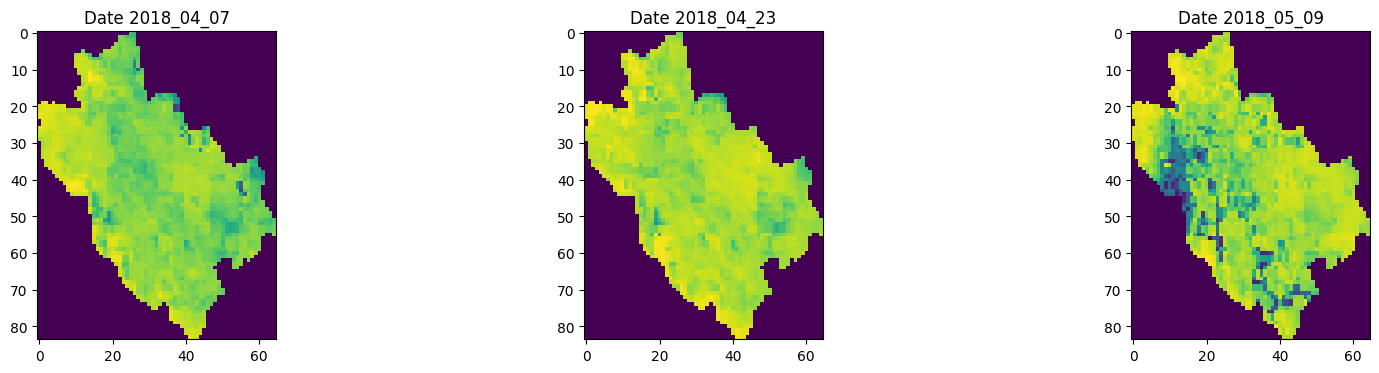

In [63]:
print('NDVI Actual Output')
fig = plt.figure(figsize= (20, 4))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {ndvi_val_dataset_date[0][3:][i]}")
  ax.imshow(y_example_val[i])

NDVI Predicted Output


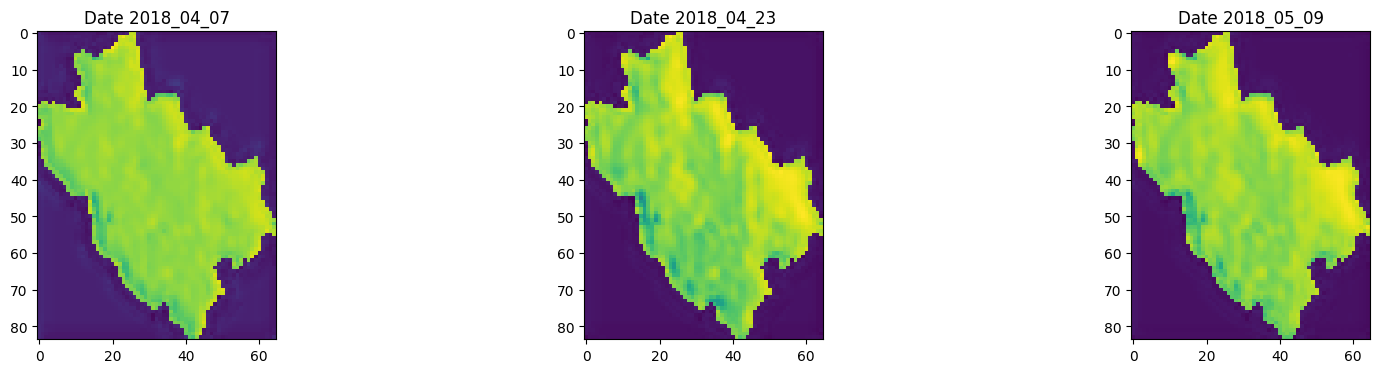

In [64]:
print('NDVI Predicted Output')
fig = plt.figure(figsize= (20, 4))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {ndvi_val_dataset_date[0][3:][i]}")
  ax.imshow(y_prediction[i])

In [ ]:
# Convert image arrays to TensorFlow tensors
y1_actual_tensor = tf.convert_to_tensor(y_example_val[1], dtype=tf.float32)
y1_pred_tensor = tf.convert_to_tensor(y_prediction[1], dtype=tf.float32)

In [ ]:
mse = tf.keras.losses.mean_squared_error(y1_actual_tensor, y1_pred_tensor)

In [ ]:
tf.reduce_mean(mse)

<tf.Tensor: shape=(), dtype=float32, numpy=0.020909157>

In [ ]:
# Calculate the mean of image_set1
mean_y1_actual = tf.reduce_mean(y1_actual_tensor, axis=0)

# Calculate the sum of squared differences (SSD) and total sum of squares (TSS)
ssd = tf.reduce_sum(tf.square(y1_pred_tensor - y1_actual_tensor), axis=[1, 2])
tss = tf.reduce_sum(tf.square(y1_pred_tensor - mean_y1_actual), axis=[1, 2])

# Calculate the R-squared value
rsquared = 1.0 - (ssd / tss)

In [ ]:
tf.reduce_mean(rsquared)

<tf.Tensor: shape=(), dtype=float32, numpy=0.45312786>

In [ ]:
y_prediction.shape

(3, 84, 65, 1)

In [ ]:
y_prediction_sc = y_prediction.copy()

In [ ]:
ndvi_scaler.data_min_

array([-1590.])

In [ ]:
y_prediction_uns = y_prediction_sc*(ndvi_scaler.data_max_ - ndvi_scaler.data_min_) + ndvi_scaler.data_min_ #.reshape(125, 125, 1)

In [ ]:
y_prediction_uns.min()

-909.0870167016983

In [ ]:
y_prediction_uns = y_prediction_uns.astype('float32') / 10000.0
y_prediction_ = y_prediction_uns.clip(-1, 1)

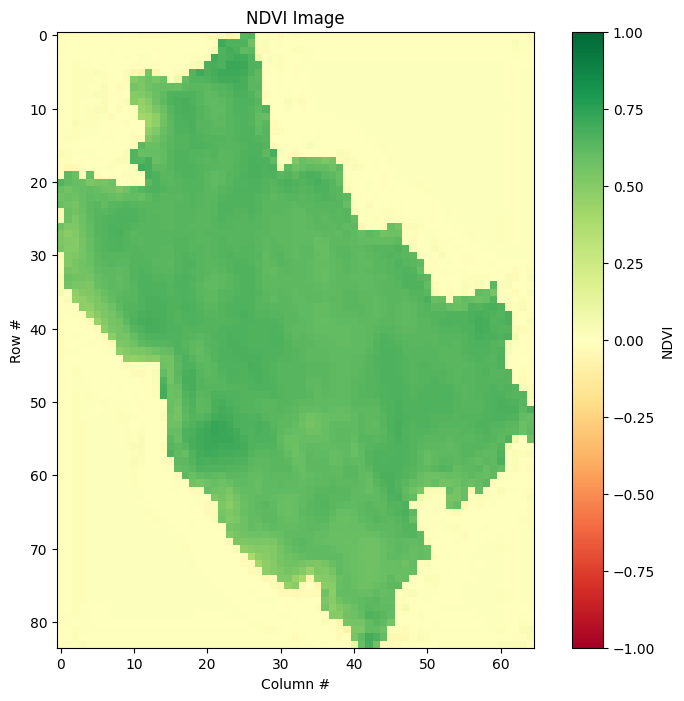

In [ ]:
# Plot the NDVI image using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(y_prediction_[-1], cmap='RdYlGn', vmin=-1, vmax=1)  # Adjust the colormap and range as needed
plt.colorbar(label='NDVI')
plt.title('NDVI Image')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

### Converting back to tiff format

In [ ]:
import os
import numpy as np
from osgeo import gdal

In [ ]:
# Define the output GeoTIFF file path
output_tiff_path_1 = './summer-internship/predicted-tif-files/ndvi&lst&lai_50epoch_distinct_3to3_2022_11_17.tif'
output_tiff_path_2 = './summer-internship/predicted-tif-files/ndvi&lst&lai_50epoch_distinct_3to3_2022_12_03.tif'
output_tiff_path_3 = './summer-internship/predicted-tif-files/ndvi&lst&lai_50epoch_distinct_3to3_2022_12_19.tif'

In [ ]:
# Set up GDAL driver
driver = gdal.GetDriverByName('GTiff')

In [ ]:
width, height = 65, 84

In [ ]:
projection = 'PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'
geotransform = [1186.725317338362, 0.0, 8248059.345985923, 0.0, -698.5949154338373, 1331776.4961396875]

In [ ]:
y_prediction_[0].shape

(84, 65, 1)

In [ ]:
y_prediction_lts = np.squeeze(y_prediction_)
y_prediction_lts.shape

(3, 84, 65)

In [ ]:
# Create a new GeoTIFF file
tiff_paths = [output_tiff_path_1, output_tiff_path_2, output_tiff_path_3]
for i in range(3):
  out_data = driver.Create(tiff_paths[i], width, height, 1, gdal.GDT_Float32)
  out_data.SetGeoTransform(geotransform)
  out_data.SetProjection(projection)
  # Write the predicted NDVI values to the GeoTIFF
  out_data.GetRasterBand(1).WriteArray(y_prediction_lts[i])
  # Close the GeoTIFF file
  out_data = None

In [ ]:
transform_list[-1]

Affine(1186.725317338362, 0.0, 8248059.345985923,
       0.0, -698.5949154338373, 1331776.4961396875)

#### Predict on unseen data

In [ ]:
from datetime import datetime, timedelta

In [ ]:
ndvi_tif_files[-3:]

['./NDVI-data-65x84/2022_11_17.tif',
 './NDVI-data-65x84/2022_12_03.tif',
 './NDVI-data-65x84/2022_12_19.tif']

In [ ]:
ndvi_val_dataset_date[-3][3:]

array(['2022_08_29', '2022_09_14', '2022_09_30'], dtype='<U10')

In [ ]:
ndvi_val_dataset_date[-2][:3]

array(['2022_07_28', '2022_08_13', '2022_08_29'], dtype='<U10')

In [ ]:
ndvi_val_dataset_date[-2][3:]

array(['2022_09_14', '2022_09_30', '2022_10_16'], dtype='<U10')

In [ ]:
# last ndvi val input date
ndvi_val_dataset_date[-1][:3]

array(['2022_08_13', '2022_08_29', '2022_09_14'], dtype='<U10')

In [ ]:
# last ndvi val output date
ndvi_val_dataset_date[-1][3:]

array(['2022_09_30', '2022_10_16', '2022_11_01'], dtype='<U10')

In [ ]:
# next ndvi input date
x_test_date =  ndvi_val_dataset_date[-1][1:4]

In [ ]:
x_test_date

array(['2022_08_29', '2022_09_14', '2022_09_30'], dtype='<U10')

In [ ]:
# next ndvi output date
ndvi_val_dataset_date[-1][4:]

array(['2022_10_16', '2022_11_01'], dtype='<U10')

In [ ]:
# Define the start date
start_date = datetime(2022, 11, 1)

# Define the interval (e.g., 1 day)
interval = timedelta(days=16)

# Define the number of dates you want in the series
num_dates = 4

# Generate the series of dates
date_series = [start_date + i * interval for i in range(num_dates)]

# Print the date series
for date in date_series[1:]:
    print(date.strftime("%Y-%m-%d"))

2022-11-17
2022-12-03
2022-12-19


In [ ]:
ndvi_pred_dates = ['2022_10_16', '2022_11_01', '2022-11-17']
ndvi_pred_dates

['2022_10_16', '2022_11_01', '2022-11-17']

In [ ]:
x_test_ndvi = x_combined_val[-1, :, :, :, 0]
x_test_ndvi_lst_2 = x_test_ndvi[1:, :, :, ]
x_test_ndvi_lst_2.shape

(2, 84, 65)

In [ ]:
x_test_ndvi_fst_y = np.squeeze(y_val[-1, 0], axis=-1)

In [ ]:
x_test_ndvi_fst_y = np.expand_dims(x_test_ndvi_fst_y, axis=0)

In [ ]:
X_test_ndvi = np.concatenate((x_test_ndvi_lst_2, x_test_ndvi_fst_y), axis=0)

In [ ]:
X_test_ndvi.shape

(3, 84, 65)

NDVI input


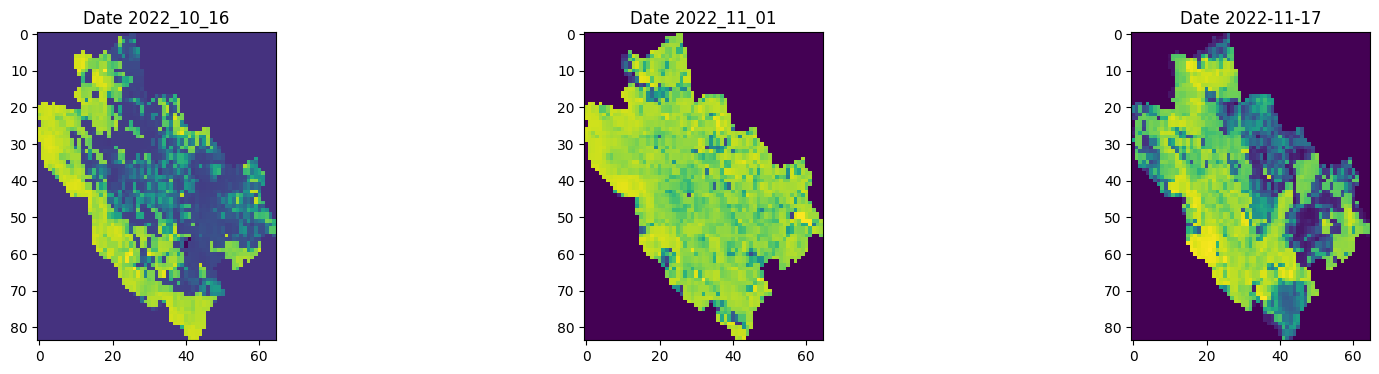

In [ ]:
print('NDVI input')
fig = plt.figure(figsize= (20, 4))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {ndvi_pred_dates[i]}")
  ax.imshow(X_test_ndvi[i])

In [ ]:
X_test_ndvi_4d = np.expand_dims(X_test_ndvi, axis=-1)
X_test_ndvi_5d_sc = np.expand_dims(X_test_ndvi_4d, axis=0)
X_test_ndvi_5d_sc.shape

(1, 3, 84, 65, 1)

In [ ]:
lst_tif_files[-3:]

['./LST-data-1km-65x84/2022_09_30.tif',
 './LST-data-1km-65x84/2022_10_16.tif',
 './LST-data-1km-65x84/2022_11_01.tif']

In [ ]:
x_test_date

array(['2022_08_29', '2022_09_14', '2022_09_30'], dtype='<U10')

In [ ]:
x_test_lst = x_combined_val[-1, :, :, :, 1]
x_test_lst_lst_2 = x_test_lst[1:, :, :, ]
x_test_lst_lst_2.shape

(2, 84, 65)

In [ ]:
#lst_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in lst_tif_files[-3:]]

In [ ]:
def collect_tif_array(tif_files):
  period_data_arr = []
  dataset = []
  period_data = []
  for file_ in tif_files:
    data = rasterio.open(file_)
    data_arr = data.read(1)
    period_data.append(data_arr)
  period_data_arr = np.array(period_data)
  dataset.append(period_data_arr)
  dataset_arr = np.array(dataset)
  dataset_arr_5d = np.expand_dims(dataset_arr, -1)
  return dataset_arr_5d

In [ ]:
data_lst = rasterio.open(lst_tif_files[-3])
data_lst_arr = data_lst.read(1)
data_lst_arr.shape

(84, 65)

In [ ]:
X_test_lst_fst_1 = np.expand_dims(data_lst_arr, axis=0)
X_test_lst_fst_1.shape

(1, 84, 65)

In [ ]:
X_test_lst_fst_1_sc = lst_scaler.transform(X_test_lst_fst_1.reshape(-1, 1))
X_test_lst_fst_1_sc = X_test_lst_fst_1_sc.reshape(1, 84, 65)

In [ ]:
X_test_lst = np.concatenate((x_test_lst_lst_2, X_test_lst_fst_1_sc), axis=0)
X_test_lst.shape

(3, 84, 65)

In [ ]:
X_test_lst_4d = np.expand_dims(X_test_lst, axis=-1)
X_test_lst_5d_sc = np.expand_dims(X_test_lst_4d, axis=0)

In [ ]:
X_test_lst_5d_sc.shape

(1, 3, 84, 65, 1)

In [ ]:
#lai_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in lai_tif_files[-3:]]

In [ ]:
x_test_lai = x_combined_val[-1, :, :, :, -1]
x_test_lai_lst_2 = x_test_lai[1:, :, :, ]
x_test_lai_lst_2.shape

(2, 84, 65)

In [ ]:
lai_tif_files[-5]

In [ ]:
data_lai = rasterio.open(lai_tif_files[-5])
data_lai_arr = data_lai.read(1)
data_lai_arr.shape

(84, 65)

In [ ]:
X_test_lai_fst_1 = np.expand_dims(data_lai_arr, axis=0)

In [ ]:
X_test_lai_fst_1_sc = lai_scaler.transform(X_test_lai_fst_1.reshape(-1, 1))
X_test_lai_fst_1_sc = X_test_lai_fst_1_sc.reshape(1, 84, 65)

In [ ]:
X_test_lai = np.concatenate((x_test_lai_lst_2, X_test_lai_fst_1_sc), axis=0)
X_test_lai_4d = np.expand_dims(X_test_lai, axis=-1)
X_test_lai_5d_sc = np.expand_dims(X_test_lai_4d, axis=0)
X_test_lai_5d_sc.shape

(1, 3, 84, 65, 1)

In [ ]:
X_test_lai.shape

(3, 84, 65)

In [ ]:
#X_test_ndvi_5d_sc = ndvi_scaler.transform(X_test_ndvi_5d.reshape(-1, 1))
#X_test_ndvi_5d_sc = X_test_ndvi_5d_sc.reshape(1, 3, 84, 65, 1)

In [ ]:
#X_test_lst_5d_sc = lst_scaler.transform(X_test_lst_5d.reshape(-1, 1))
#X_test_lst_5d_sc = X_test_lst_5d_sc.reshape(1, 3, 84, 65, 1)

In [ ]:
#X_test_lai_5d_sc = lai_scaler.transform(X_test_lai_5d.reshape(-1, 1))
#X_test_lai_5d_sc = X_test_lai_5d_sc.reshape(1, 3, 84, 65, 1)

In [ ]:
x_combined_example = np.concatenate((X_test_ndvi_5d_sc, X_test_lst_5d_sc, X_test_lai_5d_sc), axis=-1)

In [ ]:
x_combined_example.shape

(1, 3, 84, 65, 3)

In [ ]:
y_pred_5d = load_model.predict(x_combined_example)
y_pred_4d = np.squeeze(y_pred_5d, axis=0)

1/1 [==============================] - 3s 3s/step


NDVI input


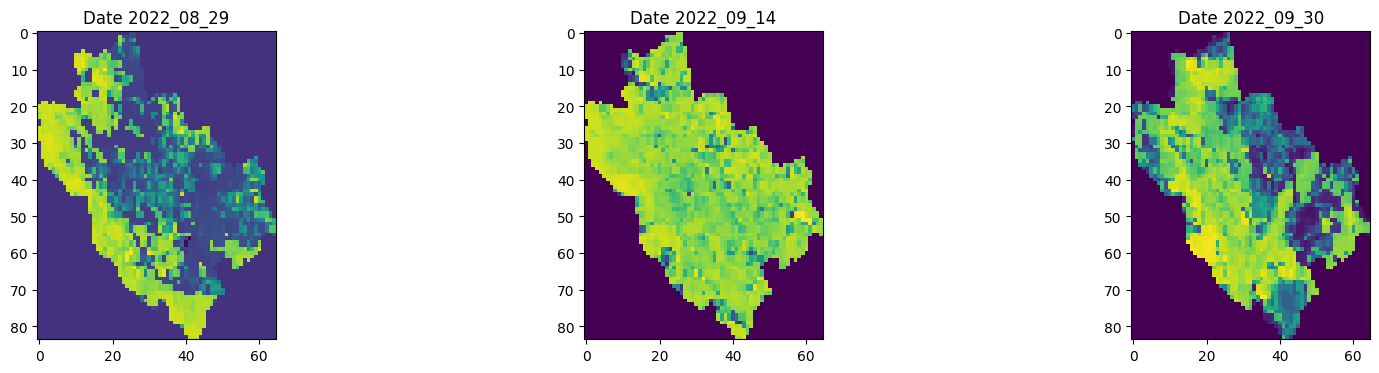

In [ ]:
print('NDVI input')
fig = plt.figure(figsize= (20, 4))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {x_test_date[i]}")
  ax.imshow(X_test_ndvi[i])

In [ ]:
ndvi_tif_files[-5:-2]

['./NDVI-data-65x84/2022_10_16.tif',
 './NDVI-data-65x84/2022_11_01.tif',
 './NDVI-data-65x84/2022_11_17.tif']

In [ ]:
y_test_ndvi_5d = collect_tif_array(ndvi_tif_files[-5:-2])
y_test_ndvi_5d.shape

(1, 3, 84, 65, 1)

In [ ]:
y_test_ndvi_5d_sc = ndvi_scaler.transform(y_test_ndvi_5d.reshape(-1, 1))
y_test_ndvi_5d_sc = y_test_ndvi_5d_sc.reshape(1, 3, 84, 65, 1)

Actual NDVI output


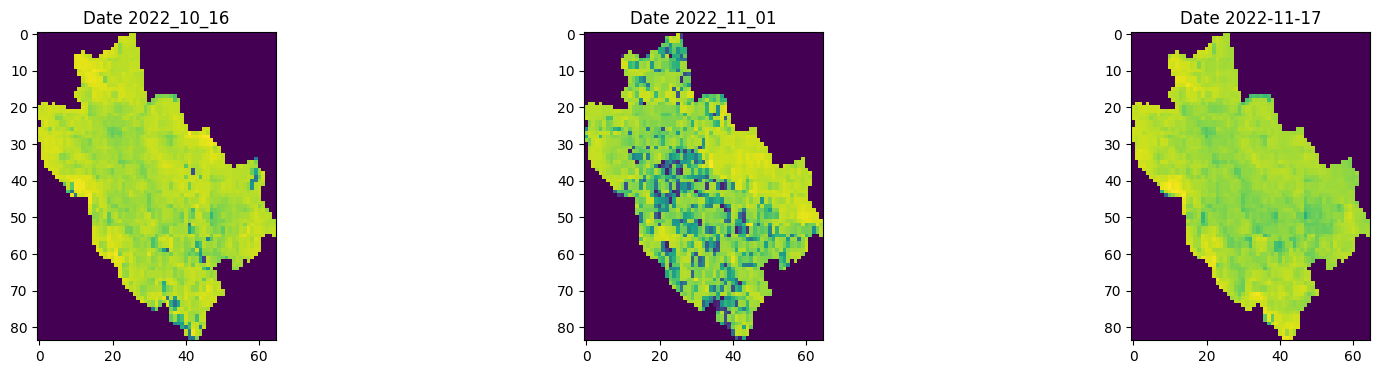

In [ ]:
print('Actual NDVI output')
fig = plt.figure(figsize= (20, 4))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {ndvi_pred_dates[i]}")
  ax.imshow(np.squeeze(y_test_ndvi_5d_sc, axis=0)[i])

Predicted NDVI output


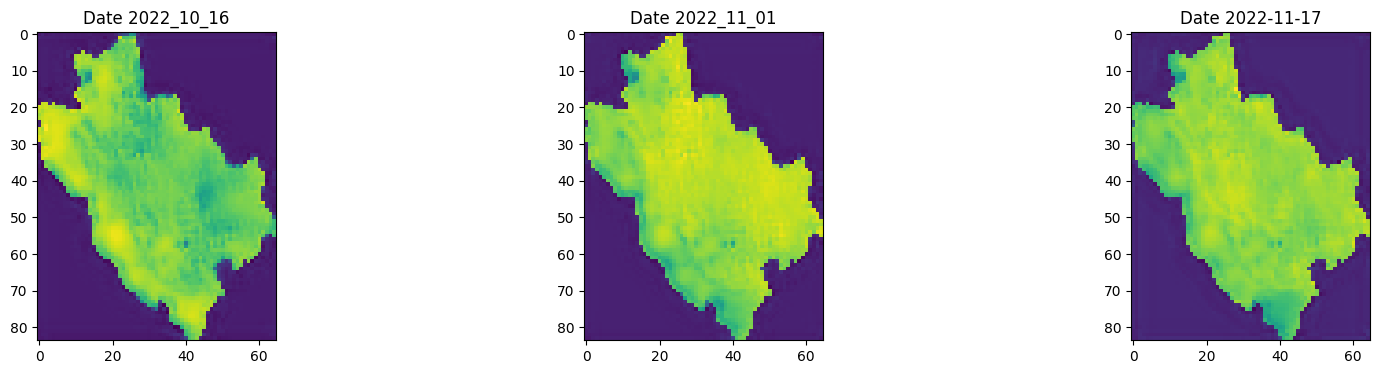

In [ ]:
print('Predicted NDVI output')
fig = plt.figure(figsize= (20, 4))
for i in range(3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.set_title(f"Date {ndvi_pred_dates[i]}")
  ax.imshow(y_pred_4d[i])

In [ ]:
scaled_y_pred_4d = (y_pred_4d - y_pred_4d.min()) / (y_pred_4d.max() - y_pred_4d.min())

In [ ]:
scaled_y_pred_4d.min(), scaled_y_pred_4d.max()

(0.0, 1.0)

In [ ]:
# MSE of last predicted frame

y1_actual_tensor = tf.convert_to_tensor(np.squeeze(y_test_ndvi_5d_sc, axis=0)[-1], dtype=tf.float32)
y1_pred_tensor = tf.convert_to_tensor(y_pred_4d[-1], dtype=tf.float32)

mse = tf.keras.losses.mean_squared_error(y1_actual_tensor, y1_pred_tensor)
tf.reduce_mean(mse)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010949676>

In [ ]:
# R2-score of last predicted frame

# Calculate the mean of image_set1
mean_y1_actual = tf.reduce_mean(y1_actual_tensor, axis=0)

# Calculate the sum of squared differences (SSD) and total sum of squares (TSS)
ssd = tf.reduce_sum(tf.square(y1_pred_tensor - y1_actual_tensor), axis=[1, 2])
tss = tf.reduce_sum(tf.square(y1_pred_tensor - mean_y1_actual), axis=[1, 2])

# Calculate the R-squared value
rsquared = 1.0 - (ssd / tss)
tf.reduce_mean(rsquared)

<tf.Tensor: shape=(), dtype=float32, numpy=0.79964983>

- Model size: 22.8 MB
- Train loss: 0.0170
- Val loss: 0.02370